In [1]:
import pandas as pd
import numpy as np

from sklearn.cluster import KMeans
import textwrap
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster._hierarchy as sch
from sklearn.datasets import make_circles
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.neighbors import NearestNeighbors
import seaborn as sns
import plotly.graph_objs as go
import plotly.figure_factory as ff

In [2]:
df1 = pd.read_csv("Olist_1.csv")
df1

,customer_unique_id,order_id,item_number,total_price_cmd,total_freight_cmd,review_score,haversine_distance,moy_photos_qty,number_of_sequential_payments,sum_of_installments_payments,...,order_purchase_periodDay,order_purchase_timestamp,order_delivered_customer_date,product_category_name_english,existing_review,m,f,date_time (Today),R (Récence),delta_purchase_delivery
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,129.90,12.00,5.0,68.656337,1.0,1.0,8.0,...,1,2018-05-10 10:56:27,2018-05-16 20:48:37,House,True,141.90,1,2022-11-16 12:24:09.861234,1651,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,18.90,8.29,4.0,13.765174,1.0,1.0,1.0,...,1,2018-05-07 11:11:27,2018-05-10 18:02:42,Health_Beauty,False,27.19,1,2022-11-16 12:24:09.861234,1654,3.0
2,0000f46a3911fa3c0805444483337064,1,1.0,69.00,17.22,3.0,320.987292,3.0,1.0,8.0,...,3,2017-03-10 21:05:03,2017-04-05 14:38:47,Other,False,86.22,1,2022-11-16 12:24:09.861234,2076,25.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1.0,25.99,17.63,4.0,1540.727062,5.0,1.0,4.0,...,3,2017-10-12 20:29:41,2017-11-01 21:23:05,Technologies,True,43.62,1,2022-11-16 12:24:09.861234,1860,20.0
4,0004aac84e0df4da2b147fca70cf8255,1,1.0,180.00,16.89,5.0,95.939915,3.0,1.0,6.0,...,3,2017-11-14 19:45:42,2017-11-27 23:08:56,Technologies,False,196.89,1,2022-11-16 12:24:09.861234,1827,13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93353,fffcf5a5ff07b0908bd4e2dbc735a684,1,2.0,1570.00,497.42,5.0,1239.685635,1.0,1.0,10.0,...,3,2017-06-08 21:00:36,2017-07-06 09:22:00,Health_Beauty,False,2067.42,1,2022-11-16 12:24:09.861234,1986,27.0
93354,fffea47cd6d3cc0a88bd621562a9d061,1,1.0,64.89,19.69,4.0,948.298541,2.0,1.0,1.0,...,3,2017-12-10 20:07:56,2018-01-09 22:28:20,Kids,False,84.58,1,2022-11-16 12:24:09.861234,1801,30.0
93355,ffff371b4d645b6ecea244b27531430a,1,1.0,89.90,22.56,5.0,947.624481,5.0,1.0,1.0,...,2,2017-02-07 15:49:16,2017-02-22 12:45:04,Auto,False,112.46,1,2022-11-16 12:24:09.861234,2107,14.0
93356,ffff5962728ec6157033ef9805bacc48,1,1.0,115.00,18.69,5.0,396.071172,3.0,1.0,5.0,...,2,2018-05-02 15:17:41,2018-05-14 11:54:26,Other,True,133.69,1,2022-11-16 12:24:09.861234,1658,11.0


In [3]:
df1['order_purchase_timestamp'].dtype

dtype('O')

In [4]:
df1['order_purchase_timestamp'] = pd.to_datetime(df1['order_purchase_timestamp'], format = '%Y-%m-%d %H:%M:%S')

In [5]:
df1['order_purchase_timestamp'].min(), df1['order_purchase_timestamp'].max()

(Timestamp('2016-09-15 12:16:38'), Timestamp('2018-08-29 15:00:37'))

In [6]:
order_purchase_time_delta = int((df1['order_purchase_timestamp'].max() - df1['order_purchase_timestamp'].min())/np.timedelta64(1,'M'))
print("La période entière des commandes porte sur {} mois.".format(order_purchase_time_delta))

La période entière des commandes porte sur 23 mois.


In [7]:
df2 = df1.copy()

In [8]:
df2 = df2[df2['order_purchase_timestamp'] >= '2017-08-29 00:00:00']
df2

,customer_unique_id,order_id,item_number,total_price_cmd,total_freight_cmd,review_score,haversine_distance,moy_photos_qty,number_of_sequential_payments,sum_of_installments_payments,...,order_purchase_periodDay,order_purchase_timestamp,order_delivered_customer_date,product_category_name_english,existing_review,m,f,date_time (Today),R (Récence),delta_purchase_delivery
0,0000366f3b9a7992bf8c76cfdf3221e2,1,1.0,129.90,12.00,5.0,68.656337,1.000000,1.0,8.0,...,1,2018-05-10 10:56:27,2018-05-16 20:48:37,House,True,141.90,1,2022-11-16 12:24:09.861234,1651,6.0
1,0000b849f77a49e4a4ce2b2a4ca5be3f,1,1.0,18.90,8.29,4.0,13.765174,1.000000,1.0,1.0,...,1,2018-05-07 11:11:27,2018-05-10 18:02:42,Health_Beauty,False,27.19,1,2022-11-16 12:24:09.861234,1654,3.0
3,0000f6ccb0745a6a4b88665a16c9f078,1,1.0,25.99,17.63,4.0,1540.727062,5.000000,1.0,4.0,...,3,2017-10-12 20:29:41,2017-11-01 21:23:05,Technologies,True,43.62,1,2022-11-16 12:24:09.861234,1860,20.0
4,0004aac84e0df4da2b147fca70cf8255,1,1.0,180.00,16.89,5.0,95.939915,3.000000,1.0,6.0,...,3,2017-11-14 19:45:42,2017-11-27 23:08:56,Technologies,False,196.89,1,2022-11-16 12:24:09.861234,1827,13.0
5,0004bd2a26a76fe21f786e4fbd80607f,1,1.0,154.00,12.98,4.0,16.883243,3.000000,1.0,8.0,...,3,2018-04-05 19:33:16,2018-04-07 16:12:43,House,False,166.98,1,2022-11-16 12:24:09.861234,1685,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
93350,fffa431dd3fcdefea4b1777d114144f2,1,1.0,64.99,16.21,5.0,277.664919,2.000000,1.0,1.0,...,3,2017-10-30 20:39:50,2017-11-10 16:19:39,Other,False,81.20,1,2022-11-16 12:24:09.861234,1842,10.0
93351,fffb09418989a0dbff854a28163e47c6,1,1.0,58.00,15.16,5.0,226.121396,1.000000,1.0,1.0,...,3,2017-12-17 19:14:35,2017-12-26 17:07:14,Other,False,73.16,1,2022-11-16 12:24:09.861234,1794,8.0
93352,fffbf87b7a1a6fa8b03f081c5f51a201,1,1.0,149.00,18.32,5.0,1470.523989,2.256378,1.0,2.0,...,0,2017-12-27 22:36:41,2018-01-15 19:39:13,Unknown,False,167.32,1,2022-11-16 12:24:09.861234,1784,18.0
93354,fffea47cd6d3cc0a88bd621562a9d061,1,1.0,64.89,19.69,4.0,948.298541,2.000000,1.0,1.0,...,3,2017-12-10 20:07:56,2018-01-09 22:28:20,Kids,False,84.58,1,2022-11-16 12:24:09.861234,1801,30.0


In [9]:
df3 = df2[['customer_unique_id', 'order_purchase_timestamp', 'R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df3

,customer_unique_id,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,1651,1,141.90,6.0,5.0,68.656337
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,1654,1,27.19,3.0,4.0,13.765174
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,1860,1,43.62,20.0,4.0,1540.727062
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,1827,1,196.89,13.0,5.0,95.939915
5,0004bd2a26a76fe21f786e4fbd80607f,2018-04-05 19:33:16,1685,1,166.98,1.0,4.0,16.883243
...,...,...,...,...,...,...,...,...
93350,fffa431dd3fcdefea4b1777d114144f2,2017-10-30 20:39:50,1842,1,81.20,10.0,5.0,277.664919
93351,fffb09418989a0dbff854a28163e47c6,2017-12-17 19:14:35,1794,1,73.16,8.0,5.0,226.121396
93352,fffbf87b7a1a6fa8b03f081c5f51a201,2017-12-27 22:36:41,1784,1,167.32,18.0,5.0,1470.523989
93354,fffea47cd6d3cc0a88bd621562a9d061,2017-12-10 20:07:56,1801,1,84.58,30.0,4.0,948.298541


In [10]:
df3.sort_values('order_purchase_timestamp', ascending=False, inplace=True)
df3

,customer_unique_id,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
13433,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,1539,1,93.75,1.0,5.0,87.870776
66821,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,1539,1,33.23,1.0,3.0,6.412264
46739,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,1539,1,61.29,1.0,5.0,267.210602
33812,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,1539,1,510.96,1.0,5.0,6.037134
44590,7a22d14aa3c3599238509ddca4b93b01,2018-08-29 12:25:59,1539,1,73.10,1.0,1.0,12.152183
...,...,...,...,...,...,...,...,...
61734,a915c8d4e27f573bb89c9bac9064290d,2017-08-29 02:04:08,1905,1,31.38,14.0,4.0,325.286519
23633,40afc4aac9be0b1ce4b1f520480edeea,2017-08-29 00:45:28,1905,1,158.79,3.0,4.0,34.501864
57924,9eb1e6e4ad8e8e4a87dc87fda7e002a4,2017-08-29 00:12:32,1905,1,80.73,8.0,5.0,18.359009
5600,0f4a442b7983c8a1a7fe12f1c4690436,2017-08-29 00:03:09,1905,1,223.78,21.0,2.0,227.035983


In [11]:
# Fonction qui permet la division du dataset en 2, à partir d'une date donnée, cela nous permettra de sélectionner le dataframe souhaité

def data_split(df, date):
    return df[df['order_purchase_timestamp'] <= date], df[df['order_purchase_timestamp'] >= date]

In [12]:
# Fonction qui permet l'ajout des périodes à incrémenter

def additional_period(pt, period_day, maximal_date):
    add_p = pd.to_datetime(pt, format = '%Y-%m-%d %H:%M:%S') + pd.DateOffset(days = period_day)
    if add_p <= maximal_date:
        return add_p
    else:
        print('La date maximale est dépassé')

In [13]:
date_fin = '2018-09-03'

In [14]:
df_inf_00, df_sup_00 = data_split(df3, date_fin)

In [15]:
df_inf_00

,customer_unique_id,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
13433,24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,1539,1,93.75,1.0,5.0,87.870776
66821,b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,1539,1,33.23,1.0,3.0,6.412264
46739,7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,1539,1,61.29,1.0,5.0,267.210602
33812,5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,1539,1,510.96,1.0,5.0,6.037134
44590,7a22d14aa3c3599238509ddca4b93b01,2018-08-29 12:25:59,1539,1,73.10,1.0,1.0,12.152183
...,...,...,...,...,...,...,...,...
61734,a915c8d4e27f573bb89c9bac9064290d,2017-08-29 02:04:08,1905,1,31.38,14.0,4.0,325.286519
23633,40afc4aac9be0b1ce4b1f520480edeea,2017-08-29 00:45:28,1905,1,158.79,3.0,4.0,34.501864
57924,9eb1e6e4ad8e8e4a87dc87fda7e002a4,2017-08-29 00:12:32,1905,1,80.73,8.0,5.0,18.359009
5600,0f4a442b7983c8a1a7fe12f1c4690436,2017-08-29 00:03:09,1905,1,223.78,21.0,2.0,227.035983


In [16]:
last_order_date = df_inf_00['order_purchase_timestamp'].max()
last_order_date

Timestamp('2018-08-29 15:00:37')

In [17]:
first_order_date = df_inf_00['order_purchase_timestamp'].min()
first_order_date

Timestamp('2017-08-29 00:01:27')

In [18]:
df_inf_00.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72678 entries, 13433 to 27661
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   customer_unique_id        72678 non-null  object        
 1   order_purchase_timestamp  72678 non-null  datetime64[ns]
 2   R (Récence)               72678 non-null  int64         
 3   f                         72678 non-null  int64         
 4   m                         72678 non-null  float64       
 5   delta_purchase_delivery   72678 non-null  float64       
 6   review_score              72678 non-null  float64       
 7   haversine_distance        72678 non-null  float64       
dtypes: datetime64[ns](1), float64(4), int64(2), object(1)
memory usage: 5.0+ MB


In [19]:
df_inf_00.set_index('customer_unique_id', inplace = True)
df_inf_00

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
24ac2b4327e25baf39f2119e4228976a,2018-08-29 15:00:37,1539,1,93.75,1.0,5.0,87.870776
b701bebbdf478f5500348f03aff62121,2018-08-29 14:52:00,1539,1,33.23,1.0,3.0,6.412264
7febafa06d9d8f232a900a2937f04338,2018-08-29 14:18:28,1539,1,61.29,1.0,5.0,267.210602
5c58de6fb80e93396e2f35642666b693,2018-08-29 14:18:23,1539,1,510.96,1.0,5.0,6.037134
7a22d14aa3c3599238509ddca4b93b01,2018-08-29 12:25:59,1539,1,73.10,1.0,1.0,12.152183
...,...,...,...,...,...,...,...
a915c8d4e27f573bb89c9bac9064290d,2017-08-29 02:04:08,1905,1,31.38,14.0,4.0,325.286519
40afc4aac9be0b1ce4b1f520480edeea,2017-08-29 00:45:28,1905,1,158.79,3.0,4.0,34.501864
9eb1e6e4ad8e8e4a87dc87fda7e002a4,2017-08-29 00:12:32,1905,1,80.73,8.0,5.0,18.359009


In [20]:
df_inf_00_ = df_inf_00[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_00_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
24ac2b4327e25baf39f2119e4228976a,1539,1,93.75,1.0,5.0,87.870776
b701bebbdf478f5500348f03aff62121,1539,1,33.23,1.0,3.0,6.412264
7febafa06d9d8f232a900a2937f04338,1539,1,61.29,1.0,5.0,267.210602
5c58de6fb80e93396e2f35642666b693,1539,1,510.96,1.0,5.0,6.037134
7a22d14aa3c3599238509ddca4b93b01,1539,1,73.10,1.0,1.0,12.152183
...,...,...,...,...,...,...
a915c8d4e27f573bb89c9bac9064290d,1905,1,31.38,14.0,4.0,325.286519
40afc4aac9be0b1ce4b1f520480edeea,1905,1,158.79,3.0,4.0,34.501864
9eb1e6e4ad8e8e4a87dc87fda7e002a4,1905,1,80.73,8.0,5.0,18.359009


In [21]:
scaler = MinMaxScaler()

In [22]:
df_inf_00_scaled = scaler.fit_transform(df_inf_00_)
df_inf_00_scaled

array([[0.        , 0.        , 0.00616354, 0.00480769, 1.        ,
        0.01630724],
       [0.        , 0.        , 0.0017313 , 0.00480769, 0.5       ,
        0.00119   ],
       [0.        , 0.        , 0.0037863 , 0.00480769, 1.        ,
        0.04958951],
       ...,
       [1.        , 0.        , 0.00521001, 0.03846154, 1.        ,
        0.0034071 ],
       [1.        , 0.        , 0.01568642, 0.10096154, 0.25      ,
        0.04213382],
       [1.        , 0.        , 0.00841628, 0.10096154, 1.        ,
        0.06058347]])

In [23]:
# Entrainement du kmeans

kmeans_model_0 = KMeans(n_clusters = 4, random_state = 42)
kmeans_model_0.fit(df_inf_00_scaled)
label_model_0 = kmeans_model_0.labels_


In [24]:
label_model_0

array([1, 0, 1, ..., 3, 2, 3])

####
### Intervalle 1

In [25]:
I_01 = '2017-09-19'

In [26]:
df_inf_01, df_sup_01 = data_split(df_inf_00, I_01)

In [27]:
df_inf_01

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
83bbd85b71fae0581d2b69e380e35171,2017-09-18 23:56:54,1884,1,183.84,28.0,1.0,841.025930
db5845a22edcc1c05394690732caa60b,2017-09-18 23:41:24,1884,1,166.69,15.0,1.0,187.926352
2cf396c9e24e7627ff042cccb209b9e6,2017-09-18 23:34:58,1884,2,429.30,13.0,3.5,180.852086
e2308203e48b22740287786fd75a8b11,2017-09-18 23:33:56,1884,1,71.82,9.0,4.0,81.434306
7480359f2bfb287f5723a3025890d06a,2017-09-18 23:29:20,1884,1,232.71,10.0,4.0,420.336208
...,...,...,...,...,...,...,...
a915c8d4e27f573bb89c9bac9064290d,2017-08-29 02:04:08,1905,1,31.38,14.0,4.0,325.286519
40afc4aac9be0b1ce4b1f520480edeea,2017-08-29 00:45:28,1905,1,158.79,3.0,4.0,34.501864
9eb1e6e4ad8e8e4a87dc87fda7e002a4,2017-08-29 00:12:32,1905,1,80.73,8.0,5.0,18.359009


In [28]:
df_inf_01_ = df_inf_01[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_01_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
83bbd85b71fae0581d2b69e380e35171,1884,1,183.84,28.0,1.0,841.025930
db5845a22edcc1c05394690732caa60b,1884,1,166.69,15.0,1.0,187.926352
2cf396c9e24e7627ff042cccb209b9e6,1884,2,429.30,13.0,3.5,180.852086
e2308203e48b22740287786fd75a8b11,1884,1,71.82,9.0,4.0,81.434306
7480359f2bfb287f5723a3025890d06a,1884,1,232.71,10.0,4.0,420.336208
...,...,...,...,...,...,...
a915c8d4e27f573bb89c9bac9064290d,1905,1,31.38,14.0,4.0,325.286519
40afc4aac9be0b1ce4b1f520480edeea,1905,1,158.79,3.0,4.0,34.501864
9eb1e6e4ad8e8e4a87dc87fda7e002a4,1905,1,80.73,8.0,5.0,18.359009


In [29]:
df_inf_01_scaled = scaler.fit_transform(df_inf_01_)
df_inf_01_scaled

array([[0.        , 0.        , 0.07121634, 0.26732673, 0.        ,
        0.41933192],
       [0.        , 0.        , 0.06418774, 0.13861386, 0.        ,
        0.09345036],
       [0.        , 0.5       , 0.17181346, 0.11881188, 0.625     ,
        0.08992046],
       ...,
       [1.        , 0.        , 0.02895866, 0.06930693, 1.        ,
        0.00884018],
       [1.        , 0.        , 0.08758499, 0.1980198 , 0.25      ,
        0.11296516],
       [1.        , 0.        , 0.04690106, 0.1980198 , 1.        ,
        0.16257097]])

In [30]:
# Pipeline avec le k choisi

kmeans_model_1 = KMeans(4, random_state = 42)
kmeans_model_1.fit(df_inf_01_scaled)

# Etiquette
labels_model_1 = kmeans_model_1.labels_

In [31]:
labels_model_1

array([3, 3, 2, ..., 1, 3, 1])

In [32]:
labels_predict_1 = kmeans_model_0.predict(df_inf_01_scaled)

In [33]:
labels_predict_1

array([2, 2, 1, ..., 3, 2, 3])

In [34]:
ari_01 = adjusted_rand_score(labels_model_1, labels_predict_1)
ari_01

0.6864551842612211

In [35]:
ari_score = {}

In [36]:
ari_score[I_01] = ari_01
ari_score

{'2017-09-19': 0.6864551842612211}

####
### Intervalle 2

In [37]:
nj = 21

In [38]:
I_02 = additional_period(I_01, nj, last_order_date)
I_02

Timestamp('2017-10-10 00:00:00')

In [39]:
df_inf_02 = df_inf_00.loc[(df_inf_00['order_purchase_timestamp'] > I_01) & (df_inf_00['order_purchase_timestamp'] <= I_02)]
df_inf_02

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
c154216d425e50fa232a228f6b9616bd,2017-10-09 23:55:59,1863,1,600.30,9.0,5.0,476.224116
cf8add60e7c0183121f770791961c035,2017-10-09 23:33:10,1863,1,22.68,3.0,5.0,8.665060
c2a0eb5fcaddf44f7567f4dbd0da6830,2017-10-09 23:27:36,1863,1,280.63,8.0,4.0,295.326162
9ac370ba1e5aa108afc187fd57ce9442,2017-10-09 23:26:55,1863,1,27.33,8.0,4.0,56.689266
867baeb0278332d0ec8a169c3d4b1486,2017-10-09 23:07:52,1863,1,195.22,16.0,3.0,18.158275
...,...,...,...,...,...,...,...
26cad9c9ba313f4f4883570a88f5460c,2017-09-19 02:06:24,1884,1,106.16,7.0,5.0,181.539605
e41193588c849790e4c162a04e7d4d69,2017-09-19 01:31:45,1884,1,65.56,22.0,4.0,826.116829
8fa9794287d53baf3d08e2fd2d73a44f,2017-09-19 00:19:17,1884,1,76.08,10.0,5.0,295.110834


In [40]:
df_inf_02_ = df_inf_02[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_02_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
c154216d425e50fa232a228f6b9616bd,1863,1,600.30,9.0,5.0,476.224116
cf8add60e7c0183121f770791961c035,1863,1,22.68,3.0,5.0,8.665060
c2a0eb5fcaddf44f7567f4dbd0da6830,1863,1,280.63,8.0,4.0,295.326162
9ac370ba1e5aa108afc187fd57ce9442,1863,1,27.33,8.0,4.0,56.689266
867baeb0278332d0ec8a169c3d4b1486,1863,1,195.22,16.0,3.0,18.158275
...,...,...,...,...,...,...
26cad9c9ba313f4f4883570a88f5460c,1884,1,106.16,7.0,5.0,181.539605
e41193588c849790e4c162a04e7d4d69,1884,1,65.56,22.0,4.0,826.116829
8fa9794287d53baf3d08e2fd2d73a44f,1884,1,76.08,10.0,5.0,295.110834


In [41]:
df_inf_02_scaled = scaler.fit_transform(df_inf_02_)
df_inf_02_scaled

array([[0.00000000e+00, 0.00000000e+00, 4.28974380e-02, 6.10687023e-02,
        1.00000000e+00, 2.31471335e-01],
       [0.00000000e+00, 0.00000000e+00, 5.78784260e-04, 1.52671756e-02,
        1.00000000e+00, 4.21169982e-03],
       [0.00000000e+00, 0.00000000e+00, 1.94771893e-02, 5.34351145e-02,
        7.50000000e-01, 1.43544896e-01],
       ...,
       [1.00000000e+00, 0.00000000e+00, 4.49107280e-03, 6.87022901e-02,
        1.00000000e+00, 1.43440235e-01],
       [1.00000000e+00, 0.00000000e+00, 1.82939784e-02, 1.14503817e-01,
        0.00000000e+00, 2.48992010e-01],
       [1.00000000e+00, 0.00000000e+00, 6.36296367e-03, 9.16030534e-02,
        1.00000000e+00, 5.86254745e-02]])

In [42]:

# Kmeans avec le k choisi

kmeans_model_2 = KMeans(4, random_state=42)
kmeans_model_2.fit(df_inf_02_scaled)

# Etiquette
labels_model_2 = kmeans_model_2.labels_


In [43]:
labels_model_2

array([2, 2, 2, ..., 1, 3, 1])

In [44]:
df_inf_02_scaled = scaler.fit_transform(df_inf_02_)
df_inf_02_scaled

array([[0.00000000e+00, 0.00000000e+00, 4.28974380e-02, 6.10687023e-02,
        1.00000000e+00, 2.31471335e-01],
       [0.00000000e+00, 0.00000000e+00, 5.78784260e-04, 1.52671756e-02,
        1.00000000e+00, 4.21169982e-03],
       [0.00000000e+00, 0.00000000e+00, 1.94771893e-02, 5.34351145e-02,
        7.50000000e-01, 1.43544896e-01],
       ...,
       [1.00000000e+00, 0.00000000e+00, 4.49107280e-03, 6.87022901e-02,
        1.00000000e+00, 1.43440235e-01],
       [1.00000000e+00, 0.00000000e+00, 1.82939784e-02, 1.14503817e-01,
        0.00000000e+00, 2.48992010e-01],
       [1.00000000e+00, 0.00000000e+00, 6.36296367e-03, 9.16030534e-02,
        1.00000000e+00, 5.86254745e-02]])

In [45]:
labels_predict_2 = kmeans_model_1.predict(df_inf_02_scaled)

In [46]:
labels_predict_2

array([2, 2, 2, ..., 1, 3, 1])

In [47]:
ari_02 = adjusted_rand_score(labels_model_2, labels_predict_2)
ari_02

0.9703524800217207

In [48]:
ari_score[I_02] = ari_02
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207}

####
### Intervalle 3

In [49]:
I_03 = additional_period(I_02, nj, last_order_date)
I_03

Timestamp('2017-10-31 00:00:00')

In [50]:
df_inf_03 = df_inf_00.loc[(df_inf_00['order_purchase_timestamp'] > I_02) & (df_inf_00['order_purchase_timestamp'] <= I_03)]
df_inf_03

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
7076410a88aad104a29286c43a894453,2017-10-30 23:58:49,1842,1,319.11,8.0,5.0,695.251930
1e93052ca04eb5b8acffe45b9b6bb66c,2017-10-30 23:55:00,1842,1,60.53,24.0,5.0,1497.234912
c379a32aeeabb565ff46fb859ffd85fa,2017-10-30 23:52:37,1842,1,279.04,7.0,5.0,23.122933
be15cf7cb42b3cc516cd4c5188cf2fb6,2017-10-30 23:33:31,1842,1,61.01,8.0,5.0,257.678579
b84bbab81298049dc58935109becbbcd,2017-10-30 23:31:49,1842,1,112.76,7.0,5.0,316.108377
...,...,...,...,...,...,...,...
b58f03f2b8052e2284e206fc895778e1,2017-10-10 01:08:25,1863,1,28.75,10.0,5.0,290.672842
d8040447345a69f29cc595c5c6df5b3b,2017-10-10 01:06:52,1863,1,100.83,7.0,1.0,334.541188
92229a5aec9b0ce20826be85c841baa3,2017-10-10 00:45:51,1863,1,330.52,15.0,5.0,822.518902


In [51]:
df_inf_03_ = df_inf_03[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_03_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
7076410a88aad104a29286c43a894453,1842,1,319.11,8.0,5.0,695.251930
1e93052ca04eb5b8acffe45b9b6bb66c,1842,1,60.53,24.0,5.0,1497.234912
c379a32aeeabb565ff46fb859ffd85fa,1842,1,279.04,7.0,5.0,23.122933
be15cf7cb42b3cc516cd4c5188cf2fb6,1842,1,61.01,8.0,5.0,257.678579
b84bbab81298049dc58935109becbbcd,1842,1,112.76,7.0,5.0,316.108377
...,...,...,...,...,...,...
b58f03f2b8052e2284e206fc895778e1,1863,1,28.75,10.0,5.0,290.672842
d8040447345a69f29cc595c5c6df5b3b,1863,1,100.83,7.0,1.0,334.541188
92229a5aec9b0ce20826be85c841baa3,1863,1,330.52,15.0,5.0,822.518902


In [52]:
df_inf_03_scaled = scaler.fit_transform(df_inf_03_)
df_inf_03_scaled

array([[0.        , 0.        , 0.09871359, 0.06481481, 1.        ,
        0.33734002],
       [0.        , 0.        , 0.01569889, 0.21296296, 1.        ,
        0.72646652],
       [0.        , 0.        , 0.08584949, 0.05555556, 1.        ,
        0.01121937],
       ...,
       [1.        , 0.        , 0.10237666, 0.12962963, 1.        ,
        0.39909064],
       [1.        , 0.        , 0.01478392, 0.05555556, 1.        ,
        0.00487899],
       [1.        , 0.        , 0.01764761, 0.12037037, 1.        ,
        0.10910098]])

In [53]:

# Kmeans avec le k choisi

kmeans_model_3 = KMeans(4, random_state=42)
kmeans_model_3.fit(df_inf_03_scaled)

# Etiquette
labels_model_3 = kmeans_model_3.labels_

In [54]:
labels_model_3

array([2, 3, 2, ..., 0, 0, 0])

In [55]:
labels_predict_3 = kmeans_model_2.predict(df_inf_03_scaled)
labels_predict_3

array([2, 0, 2, ..., 1, 1, 1])

In [56]:

ari_03 = adjusted_rand_score(labels_model_3, labels_predict_3)
ari_03

0.9556678730363262

In [57]:
ari_score[I_03] = ari_03
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262}

####
### Intervalle 4

In [58]:
I_04 = additional_period(I_03, nj, last_order_date)
I_04

Timestamp('2017-11-21 00:00:00')

In [59]:
df_inf_04 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_03) & (df_inf_00['order_purchase_timestamp'] <= I_04)]
df_inf_04

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
58f4f93513df408ed8b2c2469e5cf33c,2017-11-20 23:45:24,1821,1,116.06,28.0,1.0,219.318771
9e823cb684444e4ff997099a6c110539,2017-11-20 23:42:30,1821,1,60.37,7.0,5.0,177.579959
b29bd5c2f25523fa4754d058fd513707,2017-11-20 23:34:26,1821,2,137.54,3.0,5.0,75.540465
ecb12d670b10e511edd56ecda04c7314,2017-11-20 23:27:27,1821,1,102.23,2.0,5.0,74.063621
9318503cd3fcb28ff64924992bfc4e06,2017-11-20 23:07:17,1821,1,89.63,9.0,4.0,896.434000
...,...,...,...,...,...,...,...
35173058d3ac45f25ca1e8a216011e9a,2017-10-31 07:15:11,1842,1,35.00,17.0,5.0,434.265506
1c72075103f417245b9f15c1287fd6e4,2017-10-31 04:57:41,1842,1,167.51,9.0,5.0,504.585884
c8003923bd1dd8512c7ec0a94a215366,2017-10-31 04:16:46,1842,1,55.24,6.0,5.0,42.387200


In [60]:
df_inf_04_ = df_inf_04[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_04_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
58f4f93513df408ed8b2c2469e5cf33c,1821,1,116.06,28.0,1.0,219.318771
9e823cb684444e4ff997099a6c110539,1821,1,60.37,7.0,5.0,177.579959
b29bd5c2f25523fa4754d058fd513707,1821,2,137.54,3.0,5.0,75.540465
ecb12d670b10e511edd56ecda04c7314,1821,1,102.23,2.0,5.0,74.063621
9318503cd3fcb28ff64924992bfc4e06,1821,1,89.63,9.0,4.0,896.434000
...,...,...,...,...,...,...
35173058d3ac45f25ca1e8a216011e9a,1842,1,35.00,17.0,5.0,434.265506
1c72075103f417245b9f15c1287fd6e4,1842,1,167.51,9.0,5.0,504.585884
c8003923bd1dd8512c7ec0a94a215366,1842,1,55.24,6.0,5.0,42.387200


In [61]:
df_inf_04_scaled = scaler.fit_transform(df_inf_04_)
df_inf_04_scaled

array([[0.        , 0.        , 0.03228767, 0.22222222, 0.        ,
        0.06609718],
       [0.        , 0.        , 0.01472467, 0.05555556, 1.        ,
        0.05350526],
       [0.        , 0.33333333, 0.03906183, 0.02380952, 1.        ,
        0.02272161],
       ...,
       [1.        , 0.        , 0.01310681, 0.04761905, 1.        ,
        0.01271982],
       [1.        , 0.33333333, 0.02044549, 0.1031746 , 0.75      ,
        0.18246465],
       [1.        , 0.        , 0.02146099, 0.00793651, 1.        ,
        0.00305269]])

In [62]:

# Kmeans avec le k choisi

kmeans_model_4 = KMeans(4, random_state=42)
kmeans_model_4.fit(df_inf_04_scaled)

# Etiquette
labels_model_4 = kmeans_model_4.labels_

In [63]:
labels_model_4

array([3, 2, 2, ..., 0, 0, 0])

In [64]:
labels_predict_4 = kmeans_model_3.predict(df_inf_04_scaled)
labels_predict_4

array([1, 2, 2, ..., 0, 0, 0])

In [65]:

ari_04 = adjusted_rand_score(labels_model_4, labels_predict_4)
ari_04

0.7102637915244074

In [66]:
ari_score[I_04] = ari_04
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074}

####
### Intervalle 5

In [67]:
I_05 = additional_period(I_04, nj, last_order_date)
I_05

Timestamp('2017-12-12 00:00:00')

In [68]:
df_inf_05 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_04) & (df_inf_00['order_purchase_timestamp'] <= I_05)]
df_inf_05

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
cdb39fc59bcd68bbe98459b8d08880f5,2017-12-11 23:55:56,1800,1,55.01,6.0,5.0,211.618224
e1afc31f60bd65fec039b9e87888b979,2017-12-11 23:55:52,1800,1,88.08,7.0,4.0,9.063483
f199ea84ac53cf917976f3d432a4ee12,2017-12-11 23:55:38,1800,1,40.76,6.0,5.0,53.346337
e833175a9cac5193854c00daf5703a07,2017-12-11 23:52:20,1800,1,92.57,10.0,5.0,52.156867
ba48fb2a1a18a927c201654e33f38e79,2017-12-11 23:43:58,1800,1,27.10,24.0,5.0,423.150358
...,...,...,...,...,...,...,...
093862d1d1cedccf9c5d15ea4da89f14,2017-11-21 02:03:56,1821,1,92.30,2.0,5.0,58.849378
9ea07065d974ed11af47d782daac5c6d,2017-11-21 01:16:32,1821,1,90.77,9.0,5.0,336.945356
f94857d9e9d320b0b0438ce3ddea22ae,2017-11-21 00:34:16,1821,1,338.17,8.0,5.0,388.770431


In [69]:
df_inf_05_ = df_inf_05[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_05_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
cdb39fc59bcd68bbe98459b8d08880f5,1800,1,55.01,6.0,5.0,211.618224
e1afc31f60bd65fec039b9e87888b979,1800,1,88.08,7.0,4.0,9.063483
f199ea84ac53cf917976f3d432a4ee12,1800,1,40.76,6.0,5.0,53.346337
e833175a9cac5193854c00daf5703a07,1800,1,92.57,10.0,5.0,52.156867
ba48fb2a1a18a927c201654e33f38e79,1800,1,27.10,24.0,5.0,423.150358
...,...,...,...,...,...,...
093862d1d1cedccf9c5d15ea4da89f14,1821,1,92.30,2.0,5.0,58.849378
9ea07065d974ed11af47d782daac5c6d,1821,1,90.77,9.0,5.0,336.945356
f94857d9e9d320b0b0438ce3ddea22ae,1821,1,338.17,8.0,5.0,388.770431


In [70]:
df_inf_05_scaled = scaler.fit_transform(df_inf_05_)
df_inf_05_scaled

array([[0.        , 0.        , 0.00679493, 0.02906977, 1.        ,
        0.06383743],
       [0.        , 0.        , 0.01224505, 0.03488372, 0.75      ,
        0.00273412],
       [0.        , 0.        , 0.00444645, 0.02906977, 1.        ,
        0.01609263],
       ...,
       [1.        , 0.        , 0.05346124, 0.04069767, 1.        ,
        0.11727774],
       [1.        , 0.        , 0.09967764, 0.02906977, 1.        ,
        0.12346511],
       [1.        , 0.        , 0.00263194, 0.02906977, 1.        ,
        0.03929062]])

In [71]:

# Kmeans avec le k choisi

kmeans_model_5 = KMeans(4, random_state=42)
kmeans_model_5.fit(df_inf_05_scaled)

# Etiquette
labels_model_5 = kmeans_model_5.labels_

In [72]:
labels_model_5

array([1, 1, 1, ..., 3, 3, 3])

In [73]:
labels_predict_5 = kmeans_model_4.predict(df_inf_05_scaled)
labels_predict_5

array([2, 2, 2, ..., 0, 0, 0])

In [74]:

ari_05 = adjusted_rand_score(labels_model_5, labels_predict_5)
ari_05

0.6883429712802089

In [75]:
ari_score[I_05] = ari_05
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089}

####
### Intervalle 6

In [76]:
I_06 = additional_period(I_05, nj, last_order_date)
I_06

Timestamp('2018-01-02 00:00:00')

In [77]:
df_inf_06 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_05) & (df_inf_00['order_purchase_timestamp'] <= I_06)]
df_inf_06

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
be31ab006786747df81854035a1960f4,2018-01-01 23:50:59,1779,1,67.39,13.0,5.0,105.883009
ecebbe0d87df8e20256cdd3f4196fbea,2018-01-01 23:45:49,1779,1,105.97,31.0,5.0,696.984676
048018b271de8a57850a736e1decab48,2018-01-01 23:22:57,1779,1,259.82,15.0,5.0,337.267024
cc6658129b907dd144c8f15765d626f9,2018-01-01 23:20:33,1779,1,65.69,13.0,5.0,267.227812
c48f157c4de3d58b5087490cd61d97a8,2018-01-01 23:15:14,1779,1,42.09,7.0,4.0,305.607771
...,...,...,...,...,...,...,...
9101c89ca944110708708e96e8b2491a,2017-12-12 00:59:26,1800,1,81.21,21.0,4.0,241.786345
e890c412a8b910d4709660658d700483,2017-12-12 00:29:08,1800,1,110.02,10.0,1.0,562.479694
d2187dc7a5fe7d690a44e28ee37bf594,2017-12-12 00:24:45,1800,1,55.09,8.0,5.0,506.371650


In [78]:
df_inf_06_ = df_inf_06[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_06_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
be31ab006786747df81854035a1960f4,1779,1,67.39,13.0,5.0,105.883009
ecebbe0d87df8e20256cdd3f4196fbea,1779,1,105.97,31.0,5.0,696.984676
048018b271de8a57850a736e1decab48,1779,1,259.82,15.0,5.0,337.267024
cc6658129b907dd144c8f15765d626f9,1779,1,65.69,13.0,5.0,267.227812
c48f157c4de3d58b5087490cd61d97a8,1779,1,42.09,7.0,4.0,305.607771
...,...,...,...,...,...,...
9101c89ca944110708708e96e8b2491a,1800,1,81.21,21.0,4.0,241.786345
e890c412a8b910d4709660658d700483,1800,1,110.02,10.0,1.0,562.479694
d2187dc7a5fe7d690a44e28ee37bf594,1800,1,55.09,8.0,5.0,506.371650


In [79]:
df_inf_06_scaled = scaler.fit_transform(df_inf_06_)
df_inf_06_scaled

array([[0.        , 0.        , 0.01632649, 0.09090909, 1.        ,
        0.05094245],
       [0.        , 0.        , 0.02807572, 0.22727273, 1.        ,
        0.33611581],
       [0.        , 0.        , 0.0749295 , 0.10606061, 1.        ,
        0.16257224],
       ...,
       [1.        , 0.        , 0.01258063, 0.0530303 , 1.        ,
        0.24415573],
       [1.        , 0.        , 0.06984974, 0.28787879, 0.        ,
        0.26768631],
       [1.        , 0.        , 0.0046534 , 0.03787879, 1.        ,
        0.00536113]])

In [80]:

# Kmeans avec le k choisi

kmeans_model_6 = KMeans(4, random_state=42)
kmeans_model_6.fit(df_inf_06_scaled)

# Etiquette
labels_model_6 = kmeans_model_6.labels_

In [81]:
labels_model_6

array([3, 3, 3, ..., 1, 2, 1])

In [82]:
labels_predict_6 = kmeans_model_5.predict(df_inf_06_scaled)
labels_predict_6

array([1, 1, 1, ..., 3, 2, 3])

In [83]:

ari_06 = adjusted_rand_score(labels_model_6, labels_predict_6)
ari_06

0.6260435836584001

In [84]:
ari_score[I_06] = ari_06
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001}

####
### Intervalle 7

In [85]:
I_07 = additional_period(I_06, nj, last_order_date)
I_07

Timestamp('2018-01-23 00:00:00')

In [86]:
df_inf_07 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_06) & (df_inf_00['order_purchase_timestamp'] <= I_07)]
df_inf_07

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
471774533790e9e337b0a5bef4824d88,2018-01-22 23:58:22,1758,1,33.84,8.0,5.0,197.320132
dd6a750c92768a89a7d9c5e819df852a,2018-01-22 23:55:38,1758,1,58.62,10.0,5.0,15.894093
f8977117beaf7f10282fd90bc9bde423,2018-01-22 23:53:16,1758,1,120.77,3.0,5.0,146.372710
351a0e8f58d932eac460f4b7a8321d64,2018-01-22 23:51:49,1758,1,77.04,10.0,1.0,1356.590175
89f85ff8f63aa9404d98a83cf96cd4e4,2018-01-22 23:50:35,1758,1,119.29,22.0,2.0,1137.359829
...,...,...,...,...,...,...,...
d47f5eaacf2b4d3e082870095322b0ed,2018-01-02 06:31:44,1779,1,111.03,8.0,4.0,48.933310
a7bc069d832786d5e0230ef0c6ce236c,2018-01-02 02:28:40,1779,1,83.22,7.0,4.0,291.301829
6991bf68b10037559555b50b9ec0892a,2018-01-02 01:18:47,1779,1,109.89,6.0,4.0,15.585756


In [87]:

df_inf_07_ = df_inf_07[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_07_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
471774533790e9e337b0a5bef4824d88,1758,1,33.84,8.0,5.0,197.320132
dd6a750c92768a89a7d9c5e819df852a,1758,1,58.62,10.0,5.0,15.894093
f8977117beaf7f10282fd90bc9bde423,1758,1,120.77,3.0,5.0,146.372710
351a0e8f58d932eac460f4b7a8321d64,1758,1,77.04,10.0,1.0,1356.590175
89f85ff8f63aa9404d98a83cf96cd4e4,1758,1,119.29,22.0,2.0,1137.359829
...,...,...,...,...,...,...
d47f5eaacf2b4d3e082870095322b0ed,1779,1,111.03,8.0,4.0,48.933310
a7bc069d832786d5e0230ef0c6ce236c,1779,1,83.22,7.0,4.0,291.301829
6991bf68b10037559555b50b9ec0892a,1779,1,109.89,6.0,4.0,15.585756


In [88]:
df_inf_07_scaled = scaler.fit_transform(df_inf_07_)
df_inf_07_scaled

array([[0.        , 0.        , 0.009023  , 0.03684211, 1.        ,
        0.10123274],
       [0.        , 0.        , 0.02033827, 0.04736842, 1.        ,
        0.00815427],
       [0.        , 0.        , 0.04871778, 0.01052632, 1.        ,
        0.07509477],
       ...,
       [1.        , 0.        , 0.04374966, 0.02631579, 0.75      ,
        0.00799609],
       [1.        , 0.        , 0.07371824, 0.06842105, 0.        ,
        0.68147158],
       [1.        , 0.        , 0.0403706 , 0.13684211, 0.5       ,
        0.40283263]])

In [89]:

# Kmeans avec le k choisi

kmeans_model_7 = KMeans(4, random_state=42)
kmeans_model_7.fit(df_inf_07_scaled)

# Etiquette
labels_model_7 = kmeans_model_7.labels_

In [90]:
labels_model_7

array([2, 2, 2, ..., 3, 1, 3])

In [91]:
labels_predict_7 = kmeans_model_6.predict(df_inf_07_scaled)
labels_predict_7

array([3, 3, 3, ..., 1, 2, 2])

In [92]:

ari_07 = adjusted_rand_score(labels_model_7, labels_predict_7)
ari_07

0.87985860894732

In [93]:
ari_score[I_07] = ari_07
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732}

####
### Intervalle 8

In [94]:
I_08 = additional_period(I_07, nj, last_order_date)
I_08

Timestamp('2018-02-13 00:00:00')

In [95]:
df_inf_08 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_07) & (df_inf_00['order_purchase_timestamp'] <= I_08)]
df_inf_08

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
487ff42ade0b680bbb1c3dbcb4779329,2018-02-12 23:55:18,1737,1,61.84,13.0,5.000000,121.011082
904089b4cfa95d92587b5d9e9e12ebaa,2018-02-12 23:47:54,1737,1,86.83,8.0,5.000000,737.714745
c9e88dde299927079d22c21f72ba6e3d,2018-02-12 23:27:44,1737,1,931.62,43.0,4.153643,1212.147937
94f48c018010de09d9c471e5d819ea05,2018-02-12 23:11:00,1737,1,32.77,4.0,5.000000,50.576377
e047dae90f668bb660ad7edc1f98923b,2018-02-12 23:01:58,1737,1,118.98,9.0,3.000000,145.873409
...,...,...,...,...,...,...,...
ec898e38f1ef4afd3043f8b09b14a16e,2018-01-23 00:49:18,1758,1,108.19,15.0,5.000000,695.661519
8792a15ab5ef76ccaacba6398ea2041d,2018-01-23 00:44:09,1758,1,46.69,45.0,1.000000,456.952782
bd99f9ce70ae45607f337d482aa62684,2018-01-23 00:30:58,1758,1,67.79,9.0,5.000000,113.019420


In [96]:
df_inf_08_ = df_inf_08[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_08_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
487ff42ade0b680bbb1c3dbcb4779329,1737,1,61.84,13.0,5.000000,121.011082
904089b4cfa95d92587b5d9e9e12ebaa,1737,1,86.83,8.0,5.000000,737.714745
c9e88dde299927079d22c21f72ba6e3d,1737,1,931.62,43.0,4.153643,1212.147937
94f48c018010de09d9c471e5d819ea05,1737,1,32.77,4.0,5.000000,50.576377
e047dae90f668bb660ad7edc1f98923b,1737,1,118.98,9.0,3.000000,145.873409
...,...,...,...,...,...,...
ec898e38f1ef4afd3043f8b09b14a16e,1758,1,108.19,15.0,5.000000,695.661519
8792a15ab5ef76ccaacba6398ea2041d,1758,1,46.69,45.0,1.000000,456.952782
bd99f9ce70ae45607f337d482aa62684,1758,1,67.79,9.0,5.000000,113.019420


In [97]:
df_inf_08_scaled = scaler.fit_transform(df_inf_08_)
df_inf_08_scaled

array([[0.        , 0.        , 0.01232962, 0.07738095, 1.        ,
        0.05753274],
       [0.        , 0.        , 0.0188853 , 0.04761905, 1.        ,
        0.35073441],
       [0.        , 0.        , 0.24050095, 0.25595238, 0.78841064,
        0.5762959 ],
       ...,
       [1.        , 0.        , 0.01389049, 0.05357143, 1.        ,
        0.05373323],
       [1.        , 0.        , 0.0188853 , 0.10119048, 1.        ,
        0.2629113 ],
       [1.        , 0.        , 0.00570573, 0.14285714, 0.75      ,
        0.12712244]])

In [98]:

# Kmeans avec le k choisi

kmeans_model_8 = KMeans(4, random_state=42)
kmeans_model_8.fit(df_inf_08_scaled)

# Etiquette
labels_model_8 = kmeans_model_8.labels_

In [99]:
labels_model_8

array([2, 2, 2, ..., 0, 0, 0])

In [100]:
labels_predict_8 = kmeans_model_7.predict(df_inf_08_scaled)
labels_predict_8

array([2, 2, 0, ..., 3, 3, 3])

In [101]:

ari_08 = adjusted_rand_score(labels_model_8, labels_predict_8)
ari_08

0.7505950375892347

In [102]:
ari_score[I_08] = ari_08
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347}

####
### Intervalle 9

In [103]:
I_09 = additional_period(I_08, nj, last_order_date)
I_09

Timestamp('2018-03-06 00:00:00')

In [104]:
df_inf_09 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_08) & (df_inf_00['order_purchase_timestamp'] <= I_09)]
df_inf_09

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
3c0db381133bd9fbf8255b12defee7e7,2018-03-05 23:51:28,1716,1,169.08,8.0,5.0,145.069446
4dfdc2b505745b7fa2547c07f4d1d5d9,2018-03-05 23:50:06,1716,1,52.31,20.0,5.0,842.431024
90445636126e4dbeacad6c7ec24e4c16,2018-03-05 23:31:49,1716,1,22.79,30.0,3.0,178.420397
acf44dfee8ef086ef411e130c9b7e23d,2018-03-05 23:23:04,1716,1,492.21,23.0,4.0,339.843800
9b9ec683f4c725d34f8844616265c45b,2018-03-05 22:50:41,1716,1,165.95,21.0,4.0,1199.345744
...,...,...,...,...,...,...,...
81c8a13965f7a71bbaa1b7ae76e839c3,2018-02-13 00:59:36,1737,1,43.78,29.0,3.0,826.181440
7857512dc9a14ef806537f0443fd5d9e,2018-02-13 00:38:22,1737,1,50.63,8.0,3.0,7.873576
af90886f773a050db25c4316d0aedf49,2018-02-13 00:21:01,1737,1,138.60,20.0,4.0,509.839978


In [105]:
df_inf_09_ = df_inf_09[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_09_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
3c0db381133bd9fbf8255b12defee7e7,1716,1,169.08,8.0,5.0,145.069446
4dfdc2b505745b7fa2547c07f4d1d5d9,1716,1,52.31,20.0,5.0,842.431024
90445636126e4dbeacad6c7ec24e4c16,1716,1,22.79,30.0,3.0,178.420397
acf44dfee8ef086ef411e130c9b7e23d,1716,1,492.21,23.0,4.0,339.843800
9b9ec683f4c725d34f8844616265c45b,1716,1,165.95,21.0,4.0,1199.345744
...,...,...,...,...,...,...
81c8a13965f7a71bbaa1b7ae76e839c3,1737,1,43.78,29.0,3.0,826.181440
7857512dc9a14ef806537f0443fd5d9e,1737,1,50.63,8.0,3.0,7.873576
af90886f773a050db25c4316d0aedf49,1737,1,138.60,20.0,4.0,509.839978


In [106]:
df_inf_09_scaled = scaler.fit_transform(df_inf_09_)
df_inf_09_scaled

array([[0.        , 0.        , 0.06432348, 0.03381643, 1.        ,
        0.06909322],
       [0.        , 0.        , 0.015006  , 0.09178744, 1.        ,
        0.40123039],
       [0.        , 0.        , 0.00253831, 0.14009662, 0.5       ,
        0.0849775 ],
       ...,
       [1.        , 0.        , 0.05145034, 0.09178744, 0.75      ,
        0.24282497],
       [1.        , 0.        , 0.01487507, 0.04347826, 1.        ,
        0.13171094],
       [1.        , 0.        , 0.01952511, 0.02898551, 1.        ,
        0.06564554]])

In [107]:

# Kmeans avec le k choisi

kmeans_model_9 = KMeans(4, random_state=42)
kmeans_model_9.fit(df_inf_09_scaled)

# Etiquette
labels_model_9 = kmeans_model_9.labels_

In [108]:
labels_model_9

array([2, 2, 2, ..., 1, 1, 1])

In [109]:
labels_predict_9 = kmeans_model_8.predict(df_inf_09_scaled)
labels_predict_9

array([2, 2, 1, ..., 0, 0, 0])

In [110]:

ari_09 = adjusted_rand_score(labels_model_9, labels_predict_9)
ari_09

0.8178611413052195

In [111]:
ari_score[I_09] = ari_09
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195}

####
### Intervalle 10

In [112]:
I_10 = additional_period(I_09, nj, last_order_date)
I_10

Timestamp('2018-03-27 00:00:00')

In [113]:
df_inf_10 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_09) & (df_inf_00['order_purchase_timestamp'] <= I_10)]
df_inf_10

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
3d850129935d047bc6fc1fed1022641a,2018-03-26 23:50:49,1695,1,89.48,21.0,5.0,1743.817536
a9a77b4e25980b7ca58cb71f878abb27,2018-03-26 23:43:27,1695,1,59.78,16.0,5.0,112.842980
4c2ea7d5d0d6f073ea20fd63cd619d3d,2018-03-26 23:38:16,1695,1,162.37,14.0,5.0,1426.134770
65f9921f70c022110d5cc227be50e7b7,2018-03-26 23:38:06,1695,1,142.89,11.0,5.0,139.310019
ae16e6392fd04e6939f6b861725e6db6,2018-03-26 23:37:36,1695,1,77.92,13.0,5.0,451.934529
...,...,...,...,...,...,...,...
720581f424c67a341d5fef3a1914f29f,2018-03-06 00:47:51,1716,1,40.66,20.0,4.0,6.778959
17ca979a63dda173f34124582b248b5b,2018-03-06 00:42:20,1716,1,183.60,10.0,5.0,496.749053
4662682dade3cc1bfa04996c5225a849,2018-03-06 00:26:58,1716,1,112.83,2.0,4.0,7.286066


In [114]:
df_inf_10_ = df_inf_10[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_10_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
3d850129935d047bc6fc1fed1022641a,1695,1,89.48,21.0,5.0,1743.817536
a9a77b4e25980b7ca58cb71f878abb27,1695,1,59.78,16.0,5.0,112.842980
4c2ea7d5d0d6f073ea20fd63cd619d3d,1695,1,162.37,14.0,5.0,1426.134770
65f9921f70c022110d5cc227be50e7b7,1695,1,142.89,11.0,5.0,139.310019
ae16e6392fd04e6939f6b861725e6db6,1695,1,77.92,13.0,5.0,451.934529
...,...,...,...,...,...,...
720581f424c67a341d5fef3a1914f29f,1716,1,40.66,20.0,4.0,6.778959
17ca979a63dda173f34124582b248b5b,1716,1,183.60,10.0,5.0,496.749053
4662682dade3cc1bfa04996c5225a849,1716,1,112.83,2.0,4.0,7.286066


In [115]:
df_inf_10_scaled = scaler.fit_transform(df_inf_10_)
df_inf_10_scaled

array([[0.        , 0.        , 0.02014167, 0.19607843, 1.        ,
        0.79241967],
       [0.        , 0.        , 0.01228293, 0.14705882, 1.        ,
        0.05112861],
       [0.        , 0.        , 0.03942867, 0.12745098, 1.        ,
        0.6480303 ],
       ...,
       [1.        , 0.        , 0.02632018, 0.00980392, 0.75      ,
        0.00315214],
       [1.        , 0.        , 0.02722777, 0.26470588, 0.        ,
        0.07034121],
       [1.        , 0.        , 0.03053267, 0.34313725, 0.75      ,
        0.10064349]])

In [116]:

# Kmeans avec le k choisi

kmeans_model_10 = KMeans(4, random_state=42)
kmeans_model_10.fit(df_inf_10_scaled)

# Etiquette
labels_model_10 = kmeans_model_10.labels_

In [117]:
labels_model_10

array([0, 0, 0, ..., 2, 1, 2])

In [118]:
labels_predict_10 = kmeans_model_9.predict(df_inf_10_scaled)
labels_predict_10

array([2, 2, 2, ..., 1, 3, 1])

In [119]:

ari_10 = adjusted_rand_score(labels_model_10, labels_predict_10)
ari_10

0.8269586441910798

In [120]:
ari_score[I_10] = ari_10
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798}

####
### Intervalle 11

In [121]:
I_11 = additional_period(I_10, nj, last_order_date)
I_11

Timestamp('2018-04-17 00:00:00')

In [122]:
df_inf_11 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_10) & (df_inf_00['order_purchase_timestamp'] <= I_11)]
df_inf_11

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
10e92acf5a464233662f0a72bcbb2c6b,2018-04-16 23:49:35,1674,1,670.20,7.0,5.000000,526.678065
5979d961c6e1d37b4660dc62e1bc700d,2018-04-16 23:45:36,1674,1,118.42,6.0,5.000000,85.601122
02fdf47b3bd661072bb00a5aab1853dc,2018-04-16 23:42:17,1674,1,268.40,6.0,2.000000,567.215951
0b10db910940be094f62a77f58d086b7,2018-04-16 23:41:55,1674,1,136.60,8.0,5.000000,233.685228
7fc43d0621f1c617d3242f7531a2c166,2018-04-16 23:22:51,1674,1,216.54,22.0,5.000000,1320.477838
...,...,...,...,...,...,...,...
8645d9b2ac9b380dd02db0ea5ba6e2a8,2018-03-27 01:00:29,1695,1,87.06,22.0,3.000000,551.317856
9629571615597f3820713e054a195387,2018-03-27 00:23:35,1695,1,24.38,1.0,4.000000,8.389777
e1aee958411b38ccf9fe3b9334dfedb6,2018-03-27 00:17:22,1695,1,253.22,10.0,5.000000,526.434949


In [123]:
df_inf_11_ = df_inf_11[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_11_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
10e92acf5a464233662f0a72bcbb2c6b,1674,1,670.20,7.0,5.000000,526.678065
5979d961c6e1d37b4660dc62e1bc700d,1674,1,118.42,6.0,5.000000,85.601122
02fdf47b3bd661072bb00a5aab1853dc,1674,1,268.40,6.0,2.000000,567.215951
0b10db910940be094f62a77f58d086b7,1674,1,136.60,8.0,5.000000,233.685228
7fc43d0621f1c617d3242f7531a2c166,1674,1,216.54,22.0,5.000000,1320.477838
...,...,...,...,...,...,...
8645d9b2ac9b380dd02db0ea5ba6e2a8,1695,1,87.06,22.0,3.000000,551.317856
9629571615597f3820713e054a195387,1695,1,24.38,1.0,4.000000,8.389777
e1aee958411b38ccf9fe3b9334dfedb6,1695,1,253.22,10.0,5.000000,526.434949


In [124]:
df_inf_11_scaled = scaler.fit_transform(df_inf_11_)
df_inf_11_scaled

array([[0.        , 0.        , 0.15761367, 0.05607477, 1.        ,
        0.25632745],
       [0.        , 0.        , 0.02500198, 0.04672897, 1.        ,
        0.04166097],
       [0.        , 0.        , 0.06104733, 0.04672897, 0.25      ,
        0.27605672],
       ...,
       [1.        , 0.        , 0.05739905, 0.08411215, 1.        ,
        0.25620913],
       [1.        , 0.        , 0.04742758, 0.04672897, 0.78841064,
        0.01887654],
       [1.        , 0.        , 0.02336771, 0.07476636, 0.75      ,
        0.51337656]])

In [125]:

# Kmeans avec le k choisi

kmeans_model_11 = KMeans(4, random_state=42)
kmeans_model_11.fit(df_inf_11_scaled)

# Etiquette
labels_model_11 = kmeans_model_11.labels_

In [126]:
labels_model_11

array([0, 0, 1, ..., 2, 2, 2])

In [127]:
labels_predict_11 = kmeans_model_10.predict(df_inf_11_scaled)
labels_predict_11

array([0, 0, 3, ..., 2, 2, 2])

In [128]:

ari_11 = adjusted_rand_score(labels_model_11, labels_predict_11)
ari_11

0.6723549610424632

In [129]:
ari_score[I_11] = ari_11
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632}

####
### Intervalle 12

In [130]:
I_12 = additional_period(I_11, nj, last_order_date)
I_12

Timestamp('2018-05-08 00:00:00')

In [131]:
df_inf_12 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_11) & (df_inf_00['order_purchase_timestamp'] <= I_12)]
df_inf_12

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
7fe53ce6ebcc4a93719884627ab3f66b,2018-05-07 23:59:33,1653,1,201.96,7.0,5.0,481.124158
dcb605d0a35c2e900646a9014393628d,2018-05-07 23:56:44,1653,1,42.39,2.0,5.0,5.598402
35d68a3cffde6623481e49668e51ae08,2018-05-07 23:49:04,1653,1,38.13,15.0,5.0,452.451275
31dcb1b92cf754e8f46bfa847cd43cae,2018-05-07 23:45:58,1653,1,57.72,1.0,5.0,45.003784
e3b3b57caa0974d93ed5218dde2ff4b3,2018-05-07 23:29:24,1653,1,1311.46,7.0,4.0,150.042465
...,...,...,...,...,...,...,...
8ed59382bc7f2a312d62671973568c4f,2018-04-17 00:31:55,1674,1,31.13,7.0,5.0,215.783427
4d6365e0380d725248a1a2aa490d7f0b,2018-04-17 00:29:51,1674,1,269.44,3.0,5.0,274.168338
80ac9b7155f022c3478998f6f0cd8043,2018-04-17 00:15:54,1674,1,64.29,1.0,5.0,16.467261


In [132]:
df_inf_12_ = df_inf_12[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_12_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
7fe53ce6ebcc4a93719884627ab3f66b,1653,1,201.96,7.0,5.0,481.124158
dcb605d0a35c2e900646a9014393628d,1653,1,42.39,2.0,5.0,5.598402
35d68a3cffde6623481e49668e51ae08,1653,1,38.13,15.0,5.0,452.451275
31dcb1b92cf754e8f46bfa847cd43cae,1653,1,57.72,1.0,5.0,45.003784
e3b3b57caa0974d93ed5218dde2ff4b3,1653,1,1311.46,7.0,4.0,150.042465
...,...,...,...,...,...,...
8ed59382bc7f2a312d62671973568c4f,1674,1,31.13,7.0,5.0,215.783427
4d6365e0380d725248a1a2aa490d7f0b,1674,1,269.44,3.0,5.0,274.168338
80ac9b7155f022c3478998f6f0cd8043,1674,1,64.29,1.0,5.0,16.467261


In [133]:
df_inf_12_scaled = scaler.fit_transform(df_inf_12_)
df_inf_12_scaled

array([[0.        , 0.        , 0.05899579, 0.05825243, 1.        ,
        0.23065523],
       [0.        , 0.        , 0.00907291, 0.00970874, 1.        ,
        0.00268392],
       [0.        , 0.        , 0.00774013, 0.13592233, 1.        ,
        0.21690919],
       ...,
       [1.        , 0.        , 0.01592451, 0.        , 1.        ,
        0.00789455],
       [1.        , 0.        , 0.00700178, 0.0776699 , 0.5       ,
        0.01879415],
       [1.        , 0.        , 0.01878717, 0.05825243, 1.        ,
        0.12554937]])

In [134]:

# Kmeans avec le k choisi

kmeans_model_12 = KMeans(4, random_state=42)
kmeans_model_12.fit(df_inf_12_scaled)

# Etiquette
labels_model_12 = kmeans_model_12.labels_

In [135]:
labels_model_12

array([1, 1, 1, ..., 3, 3, 3])

In [136]:
labels_predict_12 = kmeans_model_11.predict(df_inf_12_scaled)
labels_predict_12

array([0, 0, 0, ..., 2, 2, 2])

In [137]:

ari_12 = adjusted_rand_score(labels_model_12, labels_predict_12)
ari_12

0.9629533204562484

In [138]:
ari_score[I_12] = ari_12
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632,
 Timestamp('2018-05-08 00:00:00'): 0.9629533204562484}

####
### Intervalle 13

In [139]:
I_13 = additional_period(I_12, nj, last_order_date)
I_13

Timestamp('2018-05-29 00:00:00')

In [140]:
df_inf_13 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_12) & (df_inf_00['order_purchase_timestamp'] <= I_13)]
df_inf_13

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
da75590f6cf4c7efc0e3821639c71430,2018-05-28 23:23:31,1632,1,399.49,6.0,4.0,54.344246
b89ecab6b0fc4a02fbdf36fd2839e3a6,2018-05-28 23:18:32,1632,1,358.03,14.0,5.0,425.374525
cd5317ec968d862b96ff90df43ff22b8,2018-05-28 23:15:15,1632,1,36.95,6.0,3.0,543.555468
73f97c6a5af65a71194cc2265ae82501,2018-05-28 23:06:44,1632,2,125.13,7.0,4.5,584.623648
3947ca729a860c522a64a49d762baada,2018-05-28 22:39:59,1632,1,905.93,20.0,5.0,1732.131198
...,...,...,...,...,...,...,...
3c5cc98c5d66e9df468a1149cea5db2f,2018-05-08 02:09:32,1653,1,764.52,8.0,5.0,29.732756
7fb3376b7bcbfa9bb632247c4b434512,2018-05-08 01:15:33,1653,1,239.41,6.0,5.0,360.683679
f61917dc2a134d82da0e28ada9e3b156,2018-05-08 00:45:50,1653,1,47.83,18.0,5.0,204.946878


In [141]:
df_inf_13_ = df_inf_13[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_13_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
da75590f6cf4c7efc0e3821639c71430,1632,1,399.49,6.0,4.0,54.344246
b89ecab6b0fc4a02fbdf36fd2839e3a6,1632,1,358.03,14.0,5.0,425.374525
cd5317ec968d862b96ff90df43ff22b8,1632,1,36.95,6.0,3.0,543.555468
73f97c6a5af65a71194cc2265ae82501,1632,2,125.13,7.0,4.5,584.623648
3947ca729a860c522a64a49d762baada,1632,1,905.93,20.0,5.0,1732.131198
...,...,...,...,...,...,...
3c5cc98c5d66e9df468a1149cea5db2f,1653,1,764.52,8.0,5.0,29.732756
7fb3376b7bcbfa9bb632247c4b434512,1653,1,239.41,6.0,5.0,360.683679
f61917dc2a134d82da0e28ada9e3b156,1653,1,47.83,18.0,5.0,204.946878


In [142]:
df_inf_13_scaled = scaler.fit_transform(df_inf_12_)
df_inf_13_scaled

array([[0.        , 0.        , 0.05899579, 0.05825243, 1.        ,
        0.23065523],
       [0.        , 0.        , 0.00907291, 0.00970874, 1.        ,
        0.00268392],
       [0.        , 0.        , 0.00774013, 0.13592233, 1.        ,
        0.21690919],
       ...,
       [1.        , 0.        , 0.01592451, 0.        , 1.        ,
        0.00789455],
       [1.        , 0.        , 0.00700178, 0.0776699 , 0.5       ,
        0.01879415],
       [1.        , 0.        , 0.01878717, 0.05825243, 1.        ,
        0.12554937]])

In [143]:

# Kmeans avec le k choisi

kmeans_model_13 = KMeans(4, random_state=42)
kmeans_model_13.fit(df_inf_13_scaled)

# Etiquette
labels_model_13 = kmeans_model_13.labels_

In [144]:
labels_model_13

array([1, 1, 1, ..., 3, 3, 3])

In [145]:
labels_predict_13 = kmeans_model_12.predict(df_inf_13_scaled)
labels_predict_13

array([1, 1, 1, ..., 3, 3, 3])

In [146]:

ari_13 = adjusted_rand_score(labels_model_13, labels_predict_13)
ari_13

1.0

In [147]:
ari_score[I_13] = ari_13
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632,
 Timestamp('2018-05-08 00:00:00'): 0.9629533204562484,
 Timestamp('2018-05-29 00:00:00'): 1.0}

####
### Intervalle 14

In [148]:
I_14 = additional_period(I_13, nj, last_order_date)
I_14

Timestamp('2018-06-19 00:00:00')

In [149]:
df_inf_14 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_13) & (df_inf_00['order_purchase_timestamp'] <= I_14)]
df_inf_14

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
8c2a5c47e0c02478c440038904724cd5,2018-06-18 23:49:55,1611,1,58.37,3.0,5.0,107.782673
35e410adc25fe96c55082bd4bb2daba2,2018-06-18 23:30:33,1611,1,139.24,1.0,5.0,13.662521
eeb40a1c2f9b56f9ef3166fb50b3de81,2018-06-18 23:25:55,1611,1,42.36,3.0,5.0,215.218551
4fcf03fe433130324a017681a545cdb4,2018-06-18 23:21:17,1611,1,89.10,1.0,4.0,9.283444
7345d4421257c44d2866ee8ce2c82648,2018-06-18 23:14:47,1611,1,32.22,7.0,5.0,508.714810
...,...,...,...,...,...,...,...
878ea5c2eb715531041a41cfdf83bcbb,2018-05-29 01:12:50,1632,1,226.22,14.0,4.0,220.285724
cdbc7f51db6831d1ffb450d17dd2d8a4,2018-05-29 00:19:25,1632,1,28.56,14.0,3.0,213.950026
e1388a489a08d6a5c95e531ee9053db5,2018-05-29 00:19:06,1632,1,51.69,9.0,5.0,185.266075


In [150]:
df_inf_14_ = df_inf_14[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_14_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
8c2a5c47e0c02478c440038904724cd5,1611,1,58.37,3.0,5.0,107.782673
35e410adc25fe96c55082bd4bb2daba2,1611,1,139.24,1.0,5.0,13.662521
eeb40a1c2f9b56f9ef3166fb50b3de81,1611,1,42.36,3.0,5.0,215.218551
4fcf03fe433130324a017681a545cdb4,1611,1,89.10,1.0,4.0,9.283444
7345d4421257c44d2866ee8ce2c82648,1611,1,32.22,7.0,5.0,508.714810
...,...,...,...,...,...,...
878ea5c2eb715531041a41cfdf83bcbb,1632,1,226.22,14.0,4.0,220.285724
cdbc7f51db6831d1ffb450d17dd2d8a4,1632,1,28.56,14.0,3.0,213.950026
e1388a489a08d6a5c95e531ee9053db5,1632,1,51.69,9.0,5.0,185.266075


In [151]:
df_inf_14_scaled = scaler.fit_transform(df_inf_14_)
df_inf_14_scaled

array([[0.        , 0.        , 0.01037195, 0.02205882, 1.        ,
        0.05136382],
       [0.        , 0.        , 0.02861422, 0.00735294, 1.        ,
        0.00651087],
       [0.        , 0.        , 0.00676049, 0.02205882, 1.        ,
        0.10256238],
       ...,
       [1.        , 0.        , 0.00886511, 0.06617647, 1.        ,
        0.08828853],
       [1.        , 0.        , 0.0170377 , 0.05882353, 0.        ,
        0.33809148],
       [1.        , 0.        , 0.01281944, 0.10294118, 0.75      ,
        0.11479518]])

In [152]:

# Kmeans avec le k choisi

kmeans_model_14 = KMeans(4, random_state=42)
kmeans_model_14.fit(df_inf_14_scaled)

# Etiquette
labels_model_14 = kmeans_model_14.labels_

In [153]:
labels_model_14

array([2, 2, 2, ..., 1, 0, 1])

In [154]:
labels_predict_14 = kmeans_model_13.predict(df_inf_14_scaled)
labels_predict_14

array([1, 1, 1, ..., 3, 2, 3])

In [155]:

ari_14 = adjusted_rand_score(labels_model_14, labels_predict_14)
ari_14

0.9744320903479493

In [156]:
ari_score[I_14] = ari_14
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632,
 Timestamp('2018-05-08 00:00:00'): 0.9629533204562484,
 Timestamp('2018-05-29 00:00:00'): 1.0,
 Timestamp('2018-06-19 00:00:00'): 0.9744320903479493}

####
### Intervalle 15

In [157]:
I_15 = additional_period(I_14, nj, last_order_date)
I_15

Timestamp('2018-07-10 00:00:00')

In [158]:
df_inf_15 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_14) & (df_inf_00['order_purchase_timestamp'] <= I_15)]
df_inf_15

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
edb29614fae66506fd950294c9fea702,2018-07-09 23:30:18,1590,1,144.12,15.0,5.0,747.275662
364849e1d0ec338fd949b47bfe80ec62,2018-07-09 23:08:29,1590,1,104.70,30.0,1.0,132.830738
b05a0be462115e2c6e1580b127161643,2018-07-09 22:59:16,1590,1,135.15,3.0,1.0,184.186773
03146a8b7c6feaac56b53e8e834eccd2,2018-07-09 22:51:02,1590,1,69.53,6.0,3.0,314.705863
3d1a76622ec022c19f773e757122968b,2018-07-09 22:31:06,1590,1,57.58,3.0,5.0,14.447014
...,...,...,...,...,...,...,...
3527fe1276a408f2cac54f65373c57d4,2018-06-19 03:01:18,1611,1,120.91,7.0,4.0,62.643995
5d8620f729a63db9808b84811985626c,2018-06-19 01:25:53,1611,1,33.22,6.0,5.0,507.205597
6c5ce6b9d419df2b111d90a6e85a10d6,2018-06-19 00:26:23,1611,1,120.68,5.0,5.0,9.327671


In [159]:
df_inf_15_ = df_inf_15[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_15_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
edb29614fae66506fd950294c9fea702,1590,1,144.12,15.0,5.0,747.275662
364849e1d0ec338fd949b47bfe80ec62,1590,1,104.70,30.0,1.0,132.830738
b05a0be462115e2c6e1580b127161643,1590,1,135.15,3.0,1.0,184.186773
03146a8b7c6feaac56b53e8e834eccd2,1590,1,69.53,6.0,3.0,314.705863
3d1a76622ec022c19f773e757122968b,1590,1,57.58,3.0,5.0,14.447014
...,...,...,...,...,...,...
3527fe1276a408f2cac54f65373c57d4,1611,1,120.91,7.0,4.0,62.643995
5d8620f729a63db9808b84811985626c,1611,1,33.22,6.0,5.0,507.205597
6c5ce6b9d419df2b111d90a6e85a10d6,1611,1,120.68,5.0,5.0,9.327671


In [160]:
df_inf_15_scaled = scaler.fit_transform(df_inf_15_)
df_inf_15_scaled

array([[0.        , 0.        , 0.02852347, 0.19230769, 1.        ,
        0.37733323],
       [0.        , 0.        , 0.02008397, 0.38461538, 0.        ,
        0.06679764],
       [0.        , 0.        , 0.02660307, 0.03846154, 0.        ,
        0.09275257],
       ...,
       [1.        , 0.        , 0.02350516, 0.06410256, 1.        ,
        0.00438017],
       [1.        , 0.        , 0.01902849, 0.08974359, 1.        ,
        0.04170477],
       [1.        , 0.        , 0.00355393, 0.02564103, 1.        ,
        0.00407534]])

In [161]:

# Kmeans avec le k choisi

kmeans_model_15 = KMeans(4, random_state=42)
kmeans_model_15.fit(df_inf_15_scaled)

# Etiquette
labels_model_15 = kmeans_model_15.labels_

In [162]:
labels_model_15

array([2, 3, 3, ..., 1, 1, 1])

In [163]:
labels_predict_15 = kmeans_model_14.predict(df_inf_15_scaled)
labels_predict_15

array([2, 0, 0, ..., 1, 1, 1])

In [164]:

ari_15 = adjusted_rand_score(labels_model_15, labels_predict_15)
ari_15

0.872074147278521

In [165]:
ari_score[I_15] = ari_15
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632,
 Timestamp('2018-05-08 00:00:00'): 0.9629533204562484,
 Timestamp('2018-05-29 00:00:00'): 1.0,
 Timestamp('2018-06-19 00:00:00'): 0.9744320903479493,
 Timestamp('2018-07-10 00:00:00'): 0.872074147278521}

####
### Intervalle 16

In [166]:
I_16 = additional_period(I_15, nj, last_order_date)
I_16

Timestamp('2018-07-31 00:00:00')

In [167]:
df_inf_16 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_15) & (df_inf_00['order_purchase_timestamp'] <= I_16)]
df_inf_16

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
a9669782a17a0b5e26ebbd3e67d82908,2018-07-30 23:54:48,1569,1,89.58,8.0,5.000000,270.636771
4126ee95b7096d3383d3885b8180c567,2018-07-30 23:54:39,1569,1,152.03,4.0,3.000000,181.190885
5273b85d23730ed771fe91b0abd9108f,2018-07-30 23:51:39,1569,1,57.27,3.0,5.000000,339.775948
990228d4f60cef7388323d8fc67d7169,2018-07-30 23:50:53,1569,1,53.37,6.0,5.000000,88.349191
563dc9dc9f253c5c77566643c8e4ea4c,2018-07-30 23:26:24,1569,1,128.77,6.0,5.000000,202.680596
...,...,...,...,...,...,...,...
4bb7d9f700ca1724ed6ec873680e4220,2018-07-10 06:45:51,1590,1,27.39,3.0,4.153643,20.891964
81936ea8a94431b4ccddaf0207921467,2018-07-10 01:51:19,1590,1,132.33,2.0,5.000000,106.561936
2b43c6254527a0919214430775f3b927,2018-07-10 00:32:48,1590,1,229.28,1.0,3.000000,31.422360


In [168]:
df_inf_16_ = df_inf_16[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_16_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
a9669782a17a0b5e26ebbd3e67d82908,1569,1,89.58,8.0,5.000000,270.636771
4126ee95b7096d3383d3885b8180c567,1569,1,152.03,4.0,3.000000,181.190885
5273b85d23730ed771fe91b0abd9108f,1569,1,57.27,3.0,5.000000,339.775948
990228d4f60cef7388323d8fc67d7169,1569,1,53.37,6.0,5.000000,88.349191
563dc9dc9f253c5c77566643c8e4ea4c,1569,1,128.77,6.0,5.000000,202.680596
...,...,...,...,...,...,...
4bb7d9f700ca1724ed6ec873680e4220,1590,1,27.39,3.0,4.153643,20.891964
81936ea8a94431b4ccddaf0207921467,1590,1,132.33,2.0,5.000000,106.561936
2b43c6254527a0919214430775f3b927,1590,1,229.28,1.0,3.000000,31.422360


In [169]:
df_inf_16_scaled = scaler.fit_transform(df_inf_16_)
df_inf_16_scaled

array([[0.        , 0.        , 0.01040103, 0.10447761, 1.        ,
        0.05013548],
       [0.        , 0.        , 0.01900199, 0.04477612, 0.5       ,
        0.03353435],
       [0.        , 0.        , 0.00595112, 0.02985075, 1.        ,
        0.06296769],
       ...,
       [1.        , 0.        , 0.02964128, 0.        , 0.5       ,
        0.00573736],
       [1.        , 0.        , 0.00792748, 0.07462687, 1.        ,
        0.07355158],
       [1.        , 0.        , 0.0146898 , 0.        , 1.        ,
        0.002693  ]])

In [170]:

# Kmeans avec le k choisi

kmeans_model_16 = KMeans(4, random_state=42)
kmeans_model_16.fit(df_inf_16_scaled)

# Etiquette
labels_model_16 = kmeans_model_16.labels_

In [171]:
labels_model_16

array([1, 3, 1, ..., 0, 0, 0])

In [172]:
labels_predict_16 = kmeans_model_15.predict(df_inf_16_scaled)
labels_predict_16

array([2, 2, 2, ..., 1, 1, 1])

In [173]:

ari_16 = adjusted_rand_score(labels_model_16, labels_predict_16)
ari_16

0.7203959724688447

In [174]:
ari_score[I_16] = ari_16
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632,
 Timestamp('2018-05-08 00:00:00'): 0.9629533204562484,
 Timestamp('2018-05-29 00:00:00'): 1.0,
 Timestamp('2018-06-19 00:00:00'): 0.9744320903479493,
 Timestamp('2018-07-10 00:00:00'): 0.872074147278521,
 Timestamp('2018-07-31 00:00:00'): 0.7203959724688447}

####
### Intervalle 17

In [175]:
I_17 = additional_period(I_16, nj, last_order_date)
I_17

Timestamp('2018-08-21 00:00:00')

In [176]:
df_inf_17 = df_inf_00.loc[
    (df_inf_00['order_purchase_timestamp'] > I_16) & (df_inf_00['order_purchase_timestamp'] <= I_17)]
df_inf_17

,order_purchase_timestamp,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,,
e780757b43bdb9a1abdf5bc54dfbf54e,2018-08-20 23:58:59,1548,1,143.10,6.0,5.0,356.453753
7b7d279dcd8c4096df6622f18d344569,2018-08-20 23:52:39,1548,1,179.73,6.0,3.0,999.710707
e4fe3a04efe1568d27be366187752445,2018-08-20 23:41:45,1548,1,147.16,7.0,3.0,317.174584
2bda8b5ca873c93f2e13ee19397429c8,2018-08-20 23:35:44,1548,1,226.88,4.0,1.0,14.870754
5460c602044c610414e3faa53a9f2e9c,2018-08-20 23:25:36,1548,1,239.66,6.0,5.0,437.852996
...,...,...,...,...,...,...,...
a9cf937719d2881fc6841f36dd5a709a,2018-07-31 01:14:22,1569,1,85.81,1.0,3.0,32.246003
60204fb945f6c8fe2469fb41a8f95463,2018-07-31 00:36:04,1569,1,145.11,8.0,5.0,150.605096
819c65629034acc8a0e1c096c2c6715d,2018-07-31 00:23:09,1569,2,395.29,3.0,5.0,267.355832


In [177]:
df_inf_17_ = df_inf_17[['R (Récence)', 'f', 'm', 'delta_purchase_delivery', 'review_score', 'haversine_distance']]
df_inf_17_

,R (Récence),f,m,delta_purchase_delivery,review_score,haversine_distance
customer_unique_id,,,,,,
e780757b43bdb9a1abdf5bc54dfbf54e,1548,1,143.10,6.0,5.0,356.453753
7b7d279dcd8c4096df6622f18d344569,1548,1,179.73,6.0,3.0,999.710707
e4fe3a04efe1568d27be366187752445,1548,1,147.16,7.0,3.0,317.174584
2bda8b5ca873c93f2e13ee19397429c8,1548,1,226.88,4.0,1.0,14.870754
5460c602044c610414e3faa53a9f2e9c,1548,1,239.66,6.0,5.0,437.852996
...,...,...,...,...,...,...
a9cf937719d2881fc6841f36dd5a709a,1569,1,85.81,1.0,3.0,32.246003
60204fb945f6c8fe2469fb41a8f95463,1569,1,145.11,8.0,5.0,150.605096
819c65629034acc8a0e1c096c2c6715d,1569,2,395.29,3.0,5.0,267.355832


In [178]:
df_inf_17_scaled = scaler.fit_transform(df_inf_17_)
df_inf_17_scaled

array([[0.        , 0.        , 0.02794184, 0.10204082, 1.        ,
        0.18325516],
       [0.        , 0.        , 0.03583199, 0.10204082, 0.5       ,
        0.51395768],
       [0.        , 0.        , 0.02881637, 0.12244898, 0.5       ,
        0.16306149],
       ...,
       [1.        , 0.07142857, 0.08226387, 0.04081633, 1.        ,
        0.13744935],
       [1.        , 0.        , 0.00579214, 0.04081633, 0.        ,
        0.1444356 ],
       [1.        , 0.        , 0.06147334, 0.30612245, 0.75      ,
        0.55303245]])

In [179]:

# Kmeans avec le k choisi

kmeans_model_17 = KMeans(4, random_state=42)
kmeans_model_17.fit(df_inf_17_scaled)

# Etiquette
labels_model_17 = kmeans_model_17.labels_

In [180]:
labels_model_17

array([0, 0, 0, ..., 1, 2, 3])

In [181]:
labels_predict_17 = kmeans_model_16.predict(df_inf_17_scaled)
labels_predict_17

array([1, 3, 3, ..., 0, 2, 0])

In [182]:

ari_17 = adjusted_rand_score(labels_model_17, labels_predict_17)
ari_17

0.6293239353728253

In [183]:
ari_score[I_17] = ari_17
ari_score

{'2017-09-19': 0.6864551842612211,
 Timestamp('2017-10-10 00:00:00'): 0.9703524800217207,
 Timestamp('2017-10-31 00:00:00'): 0.9556678730363262,
 Timestamp('2017-11-21 00:00:00'): 0.7102637915244074,
 Timestamp('2017-12-12 00:00:00'): 0.6883429712802089,
 Timestamp('2018-01-02 00:00:00'): 0.6260435836584001,
 Timestamp('2018-01-23 00:00:00'): 0.87985860894732,
 Timestamp('2018-02-13 00:00:00'): 0.7505950375892347,
 Timestamp('2018-03-06 00:00:00'): 0.8178611413052195,
 Timestamp('2018-03-27 00:00:00'): 0.8269586441910798,
 Timestamp('2018-04-17 00:00:00'): 0.6723549610424632,
 Timestamp('2018-05-08 00:00:00'): 0.9629533204562484,
 Timestamp('2018-05-29 00:00:00'): 1.0,
 Timestamp('2018-06-19 00:00:00'): 0.9744320903479493,
 Timestamp('2018-07-10 00:00:00'): 0.872074147278521,
 Timestamp('2018-07-31 00:00:00'): 0.7203959724688447,
 Timestamp('2018-08-21 00:00:00'): 0.6293239353728253}

####
### Intervalle 18

In [184]:
I_18 = additional_period(I_17, nj, last_order_date)
I_18

La date maximale est dépassé


####
### Affichage des résultats sur un graphique

In [185]:
Ari_score = pd.DataFrame(ari_score.items(), columns=["Period", "Ari"])
Ari_score

,Period,Ari
0,2017-09-19,0.686455
1,2017-10-10,0.970352
2,2017-10-31,0.955668
3,2017-11-21,0.710264
4,2017-12-12,0.688343
5,2018-01-02,0.626044
6,2018-01-23,0.879859
7,2018-02-13,0.750595
8,2018-03-06,0.817861
9,2018-03-27,0.826959


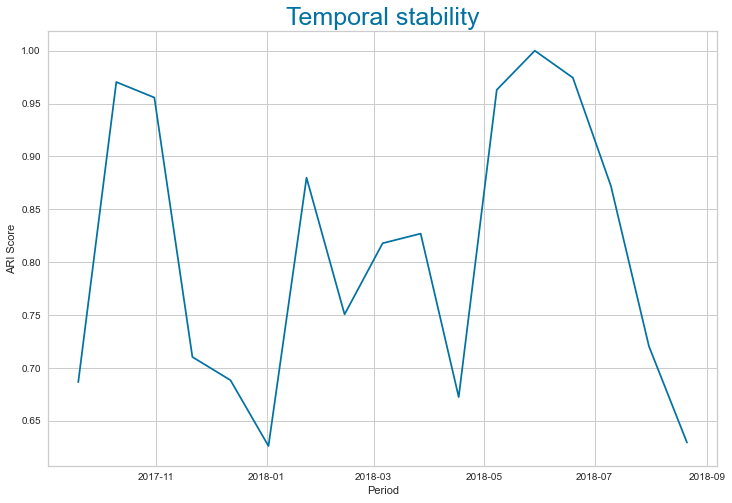

In [187]:


# plot ARI Score
fig = plt.figure(figsize=(12,8))
sns.lineplot(data=Ari_score, x="Period", y="Ari")

plt.xlabel("Period")
plt.ylabel("ARI Score")
plt.title("Temporal stability",
          fontsize=25,
          color="b")
plt.show()